In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np
import time
import torch
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
sys.path.append("./bin")
from dataset import SmilesEncoder
from vae import SmilesVAE
from rewards import RewardQED, RewardPenalizedLogP

In [4]:
output_dir = "output_1_pretrain_SmilesVAE_ZINC"

In [5]:
filepath_tokenizer = os.path.join(output_dir, "char2idx.csv")

tokenizer = SmilesEncoder(filepath_tokenizer)

Vocabulary size (including 3 special tokens): 28


In [6]:
generator = SmilesVAE(vocab_size=tokenizer.vocab_size,
                      embedding_size=16,
                      hidden_size=256,
                      latent_size=64,
                      sos_idx=tokenizer.sos_idx,
                      eos_idx=tokenizer.eos_idx,
                      pad_idx=tokenizer.pad_idx,
                      device=device)

filepath_model = os.path.join(output_dir, "SmilesVAE.pt")
generator.load_model(filepath_model)

In [7]:
rng = np.random.RandomState(2021)
latent_vectors = rng.randn(10,64)

In [8]:
smiles_per_z = []
n_generate = 1000

with torch.no_grad():
    for z in latent_vectors:
        z = torch.cuda.FloatTensor(z, device=device)
        smiles = []
        for _ in trange(n_generate):
            smi = generator.inference(z)
            smi = tokenizer.decode([smi])[0]
            smiles.append(smi)
        smiles_per_z.append(smiles)

100%|██████████| 1000/1000 [00:32<00:00, 30.42it/s]


In [9]:
smiles

['CC(C1=CC=CC=C1F)N(CC1=CC=CC(C(N)=O)=C1)C(C)=O',
 'COC1=CC(C=NNC(=O)C2=NN3CC(=O)N(C)C4=C2N=NN3C2=CC=CC=C2)=CC(C)=C1OCCC',
 'COC1=CC=C(C(=O)C2CCN(C3=NN=NN3CC3=CC=CC=N3)CC2)C=C1',
 'OC1=CC=C(CSC2=NN=C(C3=CC=CC=C3)N2C2=CC=CC=C2)C=C1',
 'COC(C1=CC=C(Cl)C=C1)C1CCC1',
 'CCC([NH3+])CC1=CC(C2CC2)NC2=CC=CC=C2C1=O',
 'CC1=CC(C)=C(C(=O)C2=CC3=CC=CC=C3N2)C(C(=O)[O-])=C1C',
 'COC1=CC=C(C=[NH+]C(CO)C(=O)[O-])C(OC)=C1OC',
 'CN(CCCC1=CC=CC=C1)C1=NC(C[NH+](C)C)=CC(O)=C1C#N',
 'CC1CN(C(=O)CSC2=NC=CN(C)C2=O)CC(C)O1',
 'COC(=O)C(C)C(N)C1=CC=C(F)C=C1',
 'COC1=CC(C(=O)N2CCC(CO)C(O)C2)=CC(OC)=C1OC',
 'CC1=NOC(CN(C)C(=O)C2=C(C)N=C(C3=CC=C4C=CC=CC4=C3)O2)=C1',
 'CC(=NNC(=O)C1CC2CCC(C1)[NH2+]2)C1=CC=C(OC(F)F)C=C1',
 'O=C(NC1=CC=C(F)C=C1Cl)C1=CC=C(C=CC2NCC(=O)N2CCCCCC(Cl)(Cl)Cl2',
 'CCC(C)(NC(=O)C1CCC1)C(=O)OC',
 'CC1=CC(NC(=O)C(C)OC2=CC=C(F)C=C2)=NC(N)=N1',
 'CC1[NH2+]CCCOC1C(=O)C1=CC=CC=C1',
 'O=C(C1=CC=CC=C1CCC1CCCCC1)N1CCCCN(C2=CC=CC(C(F)(F)F)=C2)C1',
 'CC1=CC=CC(NC(=O)CCC2=C(C3=CC=CC=C3)N=C3C(C)=NN(C)C3=N2

In [10]:
calc_qed = RewardQED() # qed = calc_qed(smi, debug=True)[1]
calc_logp = RewardPenalizedLogP() # _, clogp, sascore, numring, penalizedlogp = calc_logp(smi, debug=True)

In [24]:
frames = []

for i, smiles in enumerate(smiles_per_z):
    scores = {"LogP":[], "SAscore":[], "PenalizedLogP":[], "QED":[]}
    for smi in smiles:
        qed = calc_qed(smi, debug=True)[1]
        _, clogp, sascore, numring, penalizedlogp = calc_logp(smi, debug=True)
        scores["QED"].append(qed)
        scores["SAscore"].append(sascore)
        scores["PenalizedLogP"].append(penalizedlogp)
        scores["LogP"].append(clogp)
    df = pd.DataFrame.from_dict(scores)
    df["SMILES"] = smiles
    df["latent_vector"] = i
    frames.append(df)

In [25]:
df_merge = pd.concat(frames, ignore_index=True)
df_merge.to_csv(os.path.join(output_dir, "pointwise_distribution_ZINC.csv"), index=False)
df_merge.head()

,LogP,SAscore,PenalizedLogP,QED,SMILES,latent_vector
0,2.75930,1.836258,0.923042,0.634327,O=C(NNC(=O)C1=CC=C(F)C=C1)C1=CC2=CC=CC=C2C=C1O,0
1,1.86420,3.446696,-1.582496,0.589970,CN(C)C1=NC(N2CCC(NC3=CC=C([N+](=O)[O-])C=N3)CC...,0
2,3.10792,2.441833,0.666087,0.575373,COCCCNC1=NC=NC(CSC2=CC=C(C)C=C2)=C1N,0
3,2.21920,3.858497,-1.639297,0.858051,COC1=CC=CC(C(=O)C[NH+](C)C2CCC3=CC=CC=C32)=C1F,0
4,2.37330,2.571521,-0.198221,0.718467,C1=CC=C(C2=NOC(CCC3=CSC=C3)=N2)N=N1,0


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP
sns.set_theme(style="whitegrid")

In [27]:
points = PCA(n_components=2, random_state=2021).fit_transform(latent_vectors)
#points = UMAP(metric="euclidean", n_components=2, random_state=2021).fit_transform(latent_vectors)

In [28]:
df_z = pd.DataFrame(latent_vectors)
df_z.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.488609,0.676011,-0.418451,-0.806521,0.555876,-0.705504,1.130858,0.645002,0.106414,0.422155,...,0.972575,0.412191,-0.132086,-0.673351,1.222222,-0.926413,1.424994,-0.124790,0.705492,0.719548
1,0.141464,-0.654448,-0.672104,0.870368,1.003245,-0.366450,1.128052,0.792584,-1.750842,-0.808869,...,0.244745,0.370906,0.414232,1.196694,1.082473,0.276918,0.930367,0.335000,1.794096,-0.952598
2,-0.569924,0.246918,0.511292,-0.439804,1.790240,0.180929,0.381956,0.514857,0.591672,1.900322,...,-0.367205,0.581342,-1.286154,0.851788,0.684467,-1.346683,-0.977484,-1.514921,-1.071030,0.353427
3,-0.827718,-1.496504,-1.517695,-1.037998,0.662567,-0.624228,-0.643762,-0.686254,0.441222,0.855880,...,-1.024729,-1.040208,-0.218594,1.074709,0.469758,-1.487871,0.903421,-0.427842,0.055226,0.635421
4,-0.515867,-0.479743,-0.537734,-0.717472,-0.118957,1.229855,-0.595299,1.595965,1.583657,-0.185138,...,-1.343985,-0.581827,-0.592386,0.291863,-0.990286,-0.273891,0.956009,0.141895,-0.580610,-0.734759


In [29]:
df_points = pd.DataFrame(points, columns=["PC1", "PC2"])
df_points = df_points.merge(df_z, left_index=True, right_index=True)
df_points.to_csv(os.path.join(output_dir, "pointwise_pca_ZINC.csv"), index=False)
df_points.head()

,PC1,PC2,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
0,0.513968,4.870681,1.488609,0.676011,-0.418451,-0.806521,0.555876,-0.705504,1.130858,0.645002,...,0.972575,0.412191,-0.132086,-0.673351,1.222222,-0.926413,1.424994,-0.124790,0.705492,0.719548
1,1.558254,5.317702,0.141464,-0.654448,-0.672104,0.870368,1.003245,-0.366450,1.128052,0.792584,...,0.244745,0.370906,0.414232,1.196694,1.082473,0.276918,0.930367,0.335000,1.794096,-0.952598
2,0.816648,-1.434124,-0.569924,0.246918,0.511292,-0.439804,1.790240,0.180929,0.381956,0.514857,...,-0.367205,0.581342,-1.286154,0.851788,0.684467,-1.346683,-0.977484,-1.514921,-1.071030,0.353427
3,5.532761,-1.547209,-0.827718,-1.496504,-1.517695,-1.037998,0.662567,-0.624228,-0.643762,-0.686254,...,-1.024729,-1.040208,-0.218594,1.074709,0.469758,-1.487871,0.903421,-0.427842,0.055226,0.635421
4,-3.738698,-4.768631,-0.515867,-0.479743,-0.537734,-0.717472,-0.118957,1.229855,-0.595299,1.595965,...,-1.343985,-0.581827,-0.592386,0.291863,-0.990286,-0.273891,0.956009,0.141895,-0.580610,-0.734759


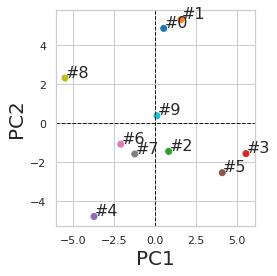

In [30]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.scatter(points[:,0], points[:,1], c=np.arange(len(points)), cmap=plt.get_cmap("tab10"))

for i in range(len(points)):
    ax.text(x=points[i,0]+0.05, y=points[i,1]+0.05, s=f"#{i}", fontsize=16)

ax.axvline(x=0, c='k', linestyle='--', linewidth=1)
ax.axhline(y=0, c='k', linestyle='--', linewidth=1)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("PC2", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join("figures", "PCA_SmilesVAE_ZINC.png"), dpi=300)
plt.show()

In [31]:
def show_kde(df, target_col, drop_zero=False, filepath=None):
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    if drop_zero:
        sns.kdeplot(data=df[df[target_col] != 0.], x=target_col, hue="latent_vector", ax=ax, palette="tab10")
    else:
        sns.kdeplot(data=df, x=target_col, hue="latent_vector", ax=ax)
    
    #ax.set_title(target_col, fontsize=28)
    ax.set_xlabel(target_col, fontsize=20)
    ax.legend().set_visible(False)
    
    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

No handles with labels found to put in legend.


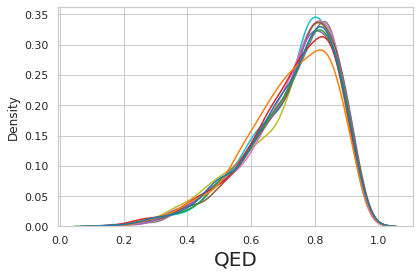

No handles with labels found to put in legend.


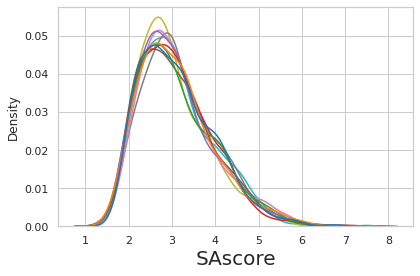

No handles with labels found to put in legend.


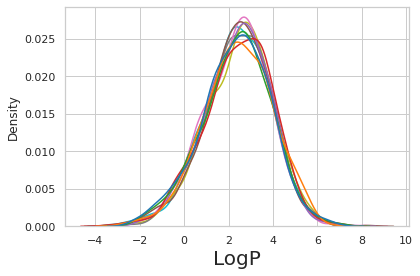

In [32]:
show_kde(df_merge, "QED", drop_zero=True, filepath=os.path.join("figures", "pointwise_distribution_SmilesVAE_ZINC_qed.png"))
show_kde(df_merge, "SAscore", drop_zero=True, filepath=os.path.join("figures", "pointwise_distribution_SmilesVAE_ZINC_sascore.png"))
show_kde(df_merge, "LogP", drop_zero=True, filepath=os.path.join("figures", "pointwise_distribution_SmilesVAE_ZINC_logp.png"))